# Normalize and train

This notebook will use the CHARM view (unbalanced_view_train_test-v1) and will:

1. Fit the standard scaler (normalizer) over train dataset
2. Normalize the train and test datasets
3. Apply DFT over dataset windows
4. Train three times with RF, SVM and KNN, and take the average accuracy and f1-score
5. Plot UMAP and T-SNE

In [1]:
import sys
sys.path.append("../..")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from umap import UMAP
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

from librep.datasets.har.loaders import CHARMUnbalancedView
from librep.datasets.multimodal import TransformMultiModalDataset, WindowedTransform
from librep.transforms.fft import FFT
from librep.utils.workflow import SimpleTrainEvalWorkflow, MultiRunWorkflow
from librep.estimators import RandomForestClassifier, SVC, KNeighborsClassifier
from librep.metrics.report import ClassificationReport
from librep.transforms.resampler import SimpleResampler

2022-09-26 22:10:13.019422: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-26 22:10:13.019441: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
# Load CHARM, creating PandasMultiModalDatasets with the correct pre-defined windows
loader = CHARMUnbalancedView("../../data/views/CHARM/unbalanced_view_train_test-v1", download=False)
train_val, test = loader.load(concat_train_validation=True)
train_val.data['activity code'] = train_val.data['activity code'].astype('int')

In [ ]:
#Selecting only classes of interest

train_val.data = train_val.data[train_val.data['activity code'].isin([0, 2, 6, 7, 8, 9])] 
test.data = test.data[test.data['activity code'].isin([0, 2, 6, 7, 8, 9])]


# labels = {0: "Sitting in a Chair", 1: "Sitting in a Couch", 2: "Standing", 3: "Lying up", 4: "Lying side", 5: "Device on surface",
# 6: "Walking", 7: "Running", 8: "Walking Upstairs", 9: "Walking Downstairs"}
# print(labels)

In [4]:
# Resampling the dataset to 20 Hz
# resampler = SimpleResampler(new_sample_size=60)
# transformer = TransformMultiModalDataset(
#     transforms=[resampler], new_window_name_prefix="resampled."
# )
# train_val = transformer(train_val)
# test = transformer(test)

In [5]:
train_val.window_names, train_val.window_slices

(['accel-x', 'accel-y', 'accel-z', 'gyro-x', 'gyro-y', 'gyro-z'],
 [(0, 60), (60, 120), (120, 180), (180, 240), (240, 300), (300, 360)])

In [6]:
# Checking the whole data...
train_val[:][0]

array([[-0.42473198, -0.3791287 , -0.28219304, ...,  4.24603783,
         5.20879079,  6.16261423],
       [-0.42473198, -0.3791287 , -0.28219304, ...,  4.24603783,
         5.20879079,  6.16261423],
       [-0.42473198, -0.3791287 , -0.28219304, ...,  4.24603783,
         5.20879079,  6.16261423],
       ...,
       [ 0.14021479, -0.37616686, -0.3367232 , ..., 10.44796981,
         8.81324234,  6.82128302],
       [ 0.14021479, -0.37616686, -0.3367232 , ..., 10.44796981,
         8.81324234,  6.82128302],
       [ 0.14021479, -0.37616686, -0.3367232 , ..., 10.44796981,
         8.81324234,  6.82128302]])

In [7]:
# 1. Perform standard scaler in train dataset
train_scaler = StandardScaler()
train_scaler.fit(train_val[:][0])
# OK Standard scaler was fit over train dataset.

StandardScaler()

Let's create the transforms. In general (by default) transforms are applyied over each window of the dataset, separadetly. We can control how transform will be applyied using Wrapping the transform arround `WindowedTransform`. 

The `WindowedTransform` receives, as argument to the constructor:

- The transform to be wrapped
- `fit_on`: can be "all" (apply fit over the whole dataset), "window" (apply fit over each window) or None (does not do fit).
- `transform_on`: can be "all" (apply transform over the whole dataset) or "window" (apply transform over each window)


Two transformers will be created:

- `scaler_transform`: First apply the scaler over the whole data (not on windows). 
- `fft_transform`: Apply the transforms over windows of the dataset

In [8]:
# Create the objects
scaler_transform = WindowedTransform(
    transform=train_scaler, fit_on=None, transform_on="all"
)
fft_transform = FFT()

# Compose the transform
# First apply the normalizer over whole dataset and then apply FFT over each window
transformer = TransformMultiModalDataset(
    transforms=[scaler_transform, fft_transform], new_window_name_prefix="scaled."
)

In [9]:
# Transform it and generate a new dataset!
train_val_fft_scaled = transformer(train_val)
test_fft_scaled = transformer(test)

In [10]:
# Checking the whole data...
train_val_fft_scaled[:][0]

array([[18.7344434 ,  0.95366736,  1.44721822, ...,  1.09541688,
         0.73279982,  0.43292263],
       [18.7344434 ,  0.95366736,  1.44721822, ...,  1.09541688,
         0.73279982,  0.43292263],
       [18.7344434 ,  0.95366736,  1.44721822, ...,  1.09541688,
         0.73279982,  0.43292263],
       ...,
       [ 0.81595157,  5.31267712,  7.30556879, ..., 14.88930615,
        10.26919543, 21.65460582],
       [ 0.81595157,  5.31267712,  7.30556879, ..., 14.88930615,
        10.26919543, 21.65460582],
       [ 0.81595157,  5.31267712,  7.30556879, ..., 14.88930615,
        10.26919543, 21.65460582]])

## Classification

Let's take the transformed datasets and train using RandomForest, SVM and KNN 3 times each. Then take the average accuracy and f1-score over the runs

In [11]:
# The reporter will be the same

reporter = ClassificationReport(
    use_accuracy=True,
    use_f1_score=True,
    use_classification_report=True,
    use_confusion_matrix=True,
    plot_confusion_matrix=True,
    normalize='true'
)

### RandomForest

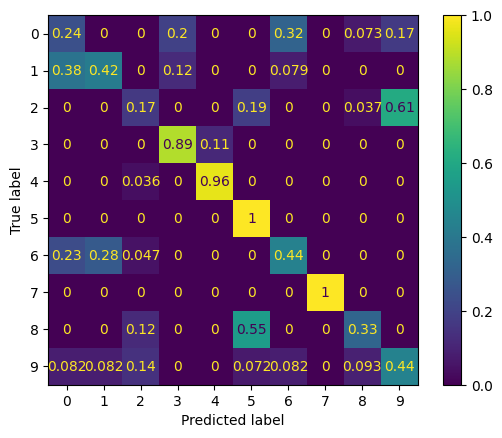

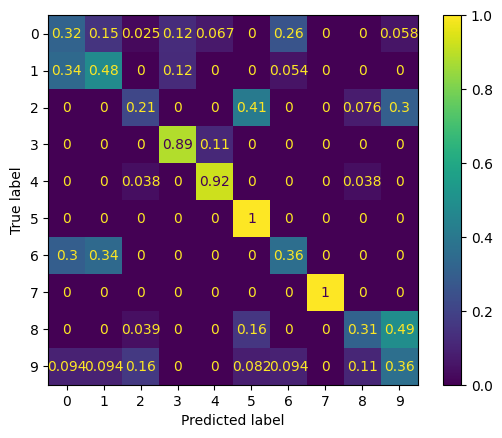

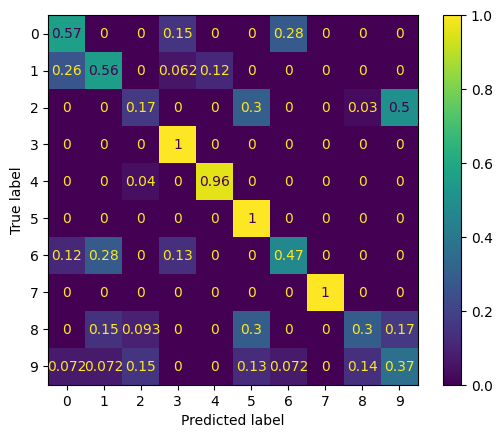

Mean accuracy (3 runs): 0.5725. Mean f1-score: 0.5681


In [12]:
experiment = SimpleTrainEvalWorkflow(
    estimator=RandomForestClassifier,
    do_not_instantiate=False,
    do_fit=True,
    evaluator=reporter,
)

multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=3, debug=False)
results = multi_run_experiment(train_val_fft_scaled, [test_fft_scaled])

mean_acc = np.average(
    [res["result"][0]["accuracy"] for res in results["runs"]]
)
mean_f1 = np.average(
    [res["result"][0]["f1 score (weighted)"] for res in results["runs"]]
)
print(f"Mean accuracy (3 runs): {mean_acc:.4f}. Mean f1-score: {mean_f1:.4f}")

### SVM

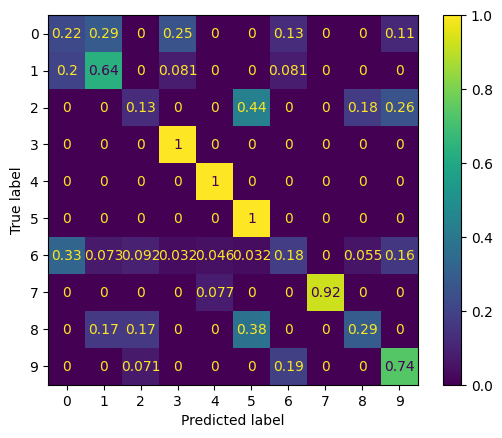

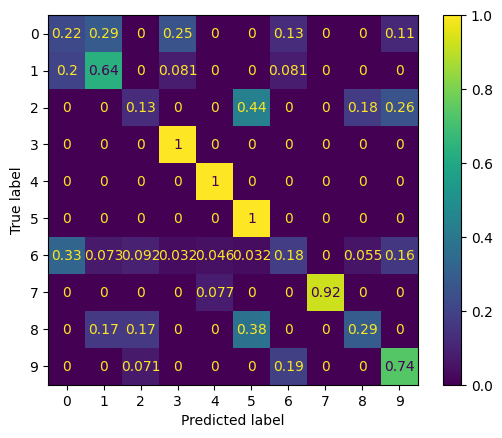

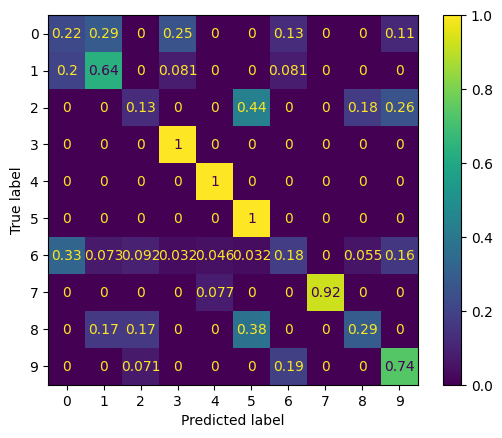

Mean accuracy (3 runs): 0.5328. Mean f1-score: 0.5085


In [13]:
experiment = SimpleTrainEvalWorkflow(
    estimator=SVC,
    do_not_instantiate=False,
    do_fit=True,
    evaluator=reporter,
)

multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=3, debug=False)
results = multi_run_experiment(train_val_fft_scaled, [test_fft_scaled])

mean_acc = np.average(
    [res["result"][0]["accuracy"] for res in results["runs"]]
)
mean_f1 = np.average(
    [res["result"][0]["f1 score (weighted)"] for res in results["runs"]]
)
print(f"Mean accuracy (3 runs): {mean_acc:.4f}. Mean f1-score: {mean_f1:.4f}")

### KNN

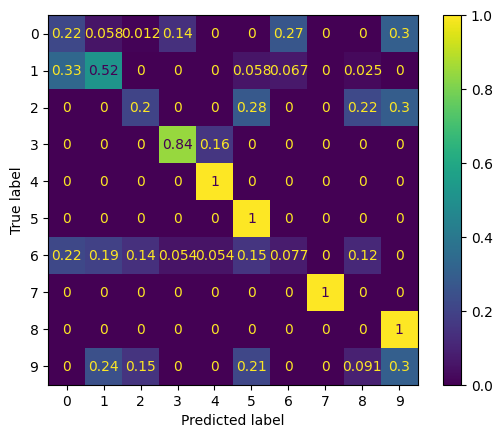

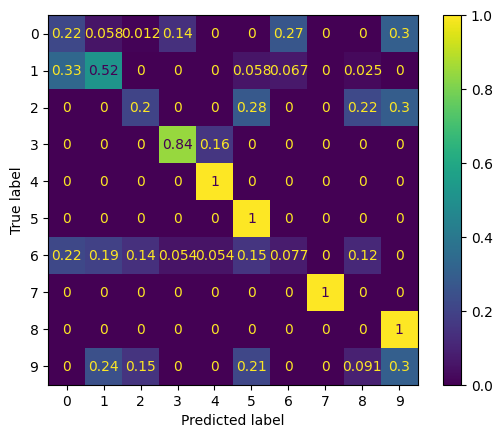

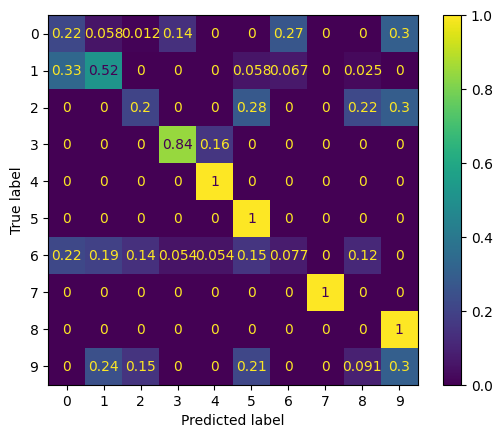

Mean accuracy (3 runs): 0.4739. Mean f1-score: 0.4597


In [14]:
experiment = SimpleTrainEvalWorkflow(
    estimator=KNeighborsClassifier,
    do_not_instantiate=False,
    do_fit=True,
    evaluator=reporter,
)

multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=3, debug=False)
results = multi_run_experiment(train_val_fft_scaled, [test_fft_scaled])

mean_acc = np.average(
    [res["result"][0]["accuracy"] for res in results["runs"]]
)
mean_f1 = np.average(
    [res["result"][0]["f1 score (weighted)"] for res in results["runs"]]
)
print(f"Mean accuracy (3 runs): {mean_acc:.4f}. Mean f1-score: {mean_f1:.4f}")

## Plot UMAP and T-SNE

In [15]:
def plot(df, figsize: tuple = (5, 5), title: str = None, labels: dict = None):
    fig, ax = plt.subplots(figsize=figsize)
    for label, group_df in df.groupby("label"):
        label = labels[label] if labels is not None else label
        ax.scatter(group_df.x, group_df.y, label=label)
    ax.legend()
    plt.title(title)
    plt.show()

In [16]:
labels = {0: "Sitting in a Chair", 1: "Sitting in a Couch", 2: "Standing", 3: "Lying up", 4: "Lying side", 5: "Device on surface",
6: "Walking", 7: "Running", 8: "Walking Upstairs", 9: "Walking Downstairs"}
print(labels)

{0: 'Sitting in a Chair', 1: 'Sitting in a Couch', 2: 'Standing', 3: 'Lying up', 4: 'Lying side', 5: 'Device on surface', 6: 'Walking', 7: 'Running', 8: 'Walking Upstairs', 9: 'Walking Downstairs'}


### UMAP

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


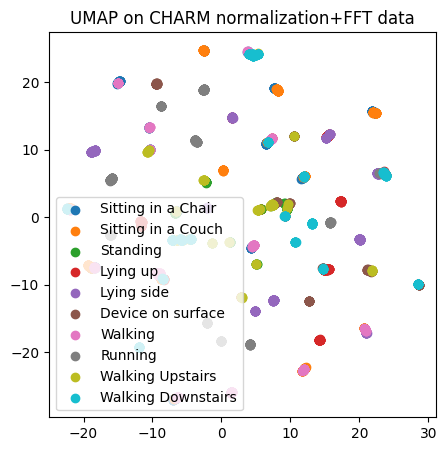

In [17]:
model = UMAP(n_components=2)
result = pd.DataFrame(model.fit_transform(train_val_fft_scaled[:][0]), columns=["x", "y"])
result["label"] = train_val_fft_scaled[:][1]
plot(result, figsize = (5, 5), title="UMAP on CHARM normalization+FFT data", labels = labels)

### T-SNE

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


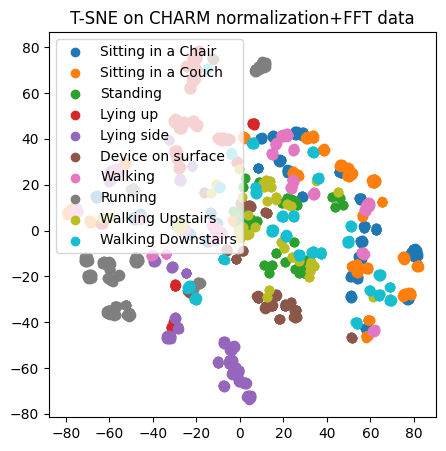

In [18]:
model = TSNE(n_components=2)
result = pd.DataFrame(model.fit_transform(train_val_fft_scaled[:][0]), columns=["x", "y"])
result["label"] = train_val_fft_scaled[:][1]
plot(result, title="T-SNE on CHARM normalization+FFT data", labels=labels)